In [129]:
import h5py as h5
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow import keras
from modules.loaders import LoadDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [130]:
###* Load the dataset
dataset = LoadDataset(h5_file= 'positions_FACES_PCA.h5').load_h5()
type(dataset)

h5py._hl.files.File

In [131]:
with dataset as h5file:
    data_h5 = []
    labels = []
    for face in h5file.keys():
        positions = h5file[face]['positions'][:]
        data_h5.append(positions)
        # print(positions.shape)
        labels.extend([face]*positions.shape[1]) #* extend is used to add the elements of the list, not the list itself  

labels = np.array(labels)
labels_letter = np.reshape(labels, (labels.shape[0], ))
labels_letter.shape


(6165,)

In [132]:
for i, id in enumerate(data_h5):
    print('Data shape',i, id.shape)

Data shape 0 (16, 1233)
Data shape 1 (16, 1233)
Data shape 2 (16, 1233)
Data shape 3 (16, 1233)
Data shape 4 (16, 1233)


#### Remember nx -> 468*2 (positions in x and y)     m -> number of samples

In [133]:
label_encoder = LabelEncoder() ###* Face TO NUMBERS 
labels = label_encoder.fit_transform(labels_letter)
print('The number of classes is:', len(label_encoder.classes_))
labels.shape

The number of classes is: 5


(6165,)

In [134]:
label_encoder.classes_

array(['Enojo', 'Feliz', 'Neutral', 'Sorpresa', 'Triste'], dtype='<U8')

### For every sample m we have one label

In [135]:
data = np.concatenate(data_h5,axis=1)
data.shape

(16, 6165)

#### sklearn needs data.shape = (m, nx), where:
#### m is the number of samples
#### nx number of featues (positions in this case)

In [136]:
data = data.T
data.shape


(6165, 16)

In [137]:
data[0,:]

array([-0.32396234,  0.52188835,  0.26421629,  0.28396354, -0.46725567,
        0.6709343 ,  0.26749381,  0.19374828,  0.22077486,  0.12051525,
        0.13160521, -0.05008458, -0.01582606, -0.02864379, -0.03207949,
       -0.04809904])

In [138]:
X_train, X, y_train, Y = train_test_split(data, labels, test_size=0.3)

In [139]:
X_train.shape, y_train.shape, X.shape, Y.shape

((4315, 16), (4315,), (1850, 16), (1850,))

#### Now we have our train dataset but we need a dev and test dataset

In [140]:
X_dev, X_test, y_dev, y_test = train_test_split(X, Y, test_size=0.5, )

In [141]:
m = X_train.shape[0] # number of samples
print(f'Traininig set: {X_train.shape[0]} samples')
print(f'Dev set: {X_dev.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Traininig set: 4315 samples
Dev set: 925 samples
Test set: 925 samples


##### We have 60% for training and 20% for dev,test data
##### Now we need to normalize the data, let's to use the z-score method

In [142]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #* Normalize X_train using the mean and standard deviation of the training set
X_dev = scaler.transform(X_dev)  #* Normalize X_test using the mean and standard deviation of the training set
X_test = scaler.transform(X_test)  #* Normalize X_test using the mean and standard deviation of the training set

### ONE HOT to create our matrix with labels

In [143]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_dev_onehot = encoder.transform(y_dev.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
y_train_onehot.shape, y_dev_onehot.shape, y_test_onehot.shape

((4315, 5), (925, 5), (925, 5))

In [144]:
# Convertir el array a una serie de pandas
import pandas as pd
y_dev_series = pd.Series(y_dev)

# Contar la frecuencia de cada elemento
element_counts = y_dev_series.value_counts()
print(element_counts)

2    200
1    190
3    187
4    182
0    166
Name: count, dtype: int64


In [145]:
1056*2

2112

#### Let's to build our first NEURAL NETWORK

Epoch 1/300


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - categorical_accuracy: 0.5170 - loss: 13.5954 - val_categorical_accuracy: 0.6800 - val_loss: 3.3317
Epoch 2/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.6866 - loss: 2.4180 - val_categorical_accuracy: 0.6908 - val_loss: 1.1496
Epoch 3/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.6884 - loss: 1.0648 - val_categorical_accuracy: 0.6951 - val_loss: 0.9628
Epoch 4/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.6982 - loss: 0.9236 - val_categorical_accuracy: 0.6703 - val_loss: 0.9804
Epoch 5/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.6830 - loss: 0.9224 - val_categorical_accuracy: 0.6951 - val_loss: 0.8984
Epoch 6/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.6932 - loss: 0.8805 - val_categorical_accuracy: 0.6595 - val_loss: 0.9076
Epoch 7/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.6670 - loss: 0.8786 -

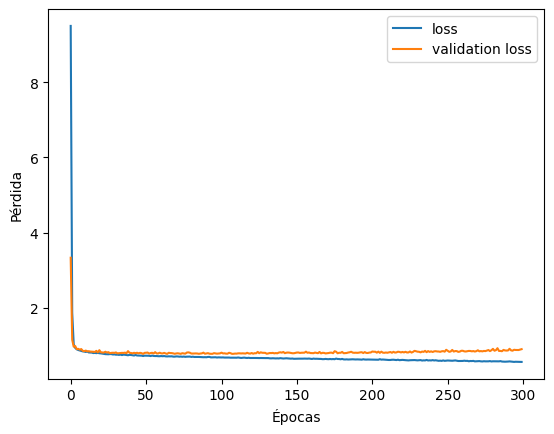

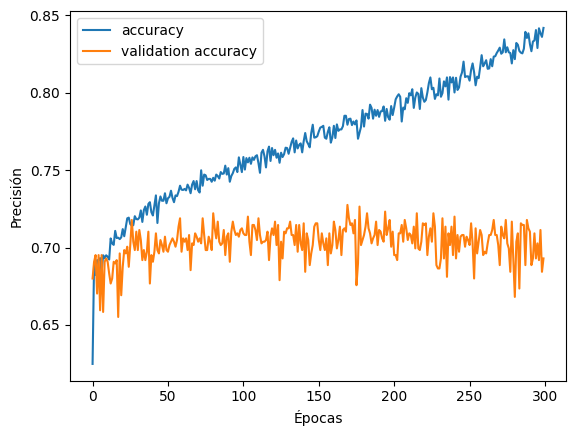

In [146]:
from tensorflow.keras.optimizers import Adam
num_classes = y_train_onehot.shape[1]  # Número de clases

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(16,)),
    tf.keras.layers.Dense(1056, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Dropout con 50% de probabilidad
    tf.keras.layers.Dense(1056, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(528, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    tf.keras.layers.Dense(528, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2

    
 
    
    # tf.keras.layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Entrenar el modelo
history = model.fit(X_train, y_train_onehot,
                    epochs=300,
                    batch_size=128,
                    validation_data=(X_dev, y_dev_onehot))
                    # callbacks=[early_stopping]

# Opcional: Graficar la pérdida y la precisión durante el entrenamiento
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


plt.plot(history.history['categorical_accuracy'], label='accuracy') 
plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [147]:
c_acuracy = history.history['categorical_accuracy'][0::30]
v_acuracy = history.history['val_categorical_accuracy'][0::30]
epocas = np.arange(1, len(history.history['categorical_accuracy']) + 1, 30)


Text(0, 0.5, 'Precisión')

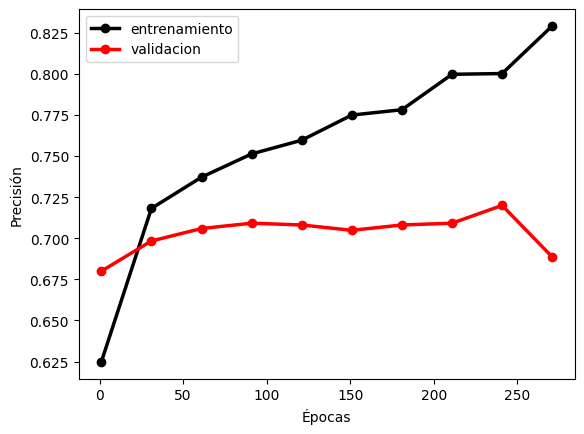

In [148]:
plt.plot(epocas,c_acuracy, label='entrenamiento', color='black', linewidth=2.5, linestyle='-', marker='o')
plt.plot(epocas,v_acuracy, label='validacion', color='red', linewidth=2.5, linestyle='-', marker='o')
plt.legend()

plt.xlabel('Épocas')
plt.ylabel('Precisión')
# plt.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\accuracy_faces.pdf')


(-0.5, 699.5, 699.5, -0.5)

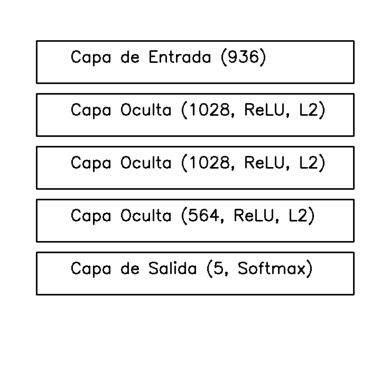

In [149]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parámetros para la red neuronal
input_shape = 936  # Número de neuronas de entrada
num_classes = 5 # Número de neuronas de salida (clases)
hidden_layers = [(1028, 'ReLU', 'L2'), (1028, 'ReLU', 'L2'),(564, 'ReLU', 'L2')]  # Capas ocultas con número de neuronas, activación y regularización

# Crear una imagen en blanco
height, width = 700, 700  # Dimensiones de la imagen
image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Fondo blanco

# Coordenadas iniciales y finales para dibujar las capas
start_x = 50
end_x = width - 50
layer_height = 100  # Altura de cada capa

# Dibujar la capa de entrada
cv2.putText(image, f'    Capa de Entrada ({input_shape})', (start_x, layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, layer_height - 40), (end_x, layer_height + 40), (0, 0, 0), 2)

# Dibujar capas ocultas
for i, (neurons, activation, regularization) in enumerate(hidden_layers, start=2):
    cv2.putText(image, f'    Capa Oculta ({neurons}, {activation}, {regularization})', 
                (start_x, i * layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.rectangle(image, (start_x, i * layer_height - 40), (end_x, i * layer_height + 40), (0, 0, 0), 2)

# Dibujar la capa de salida
cv2.putText(image, f'    Capa de Salida ({num_classes}, Softmax)', (start_x, (len(hidden_layers) + 2) * layer_height), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, (len(hidden_layers) + 2) * layer_height - 40), 
              (end_x, (len(hidden_layers) + 2) * layer_height + 40), (0, 0, 0), 2)

# Mostrar la imagen
# cv2.imshow('Red Neuronal', image)
plt.imshow(image)
plt.axis('off')



In [150]:
# Evaluar el modelo
print('***'*50)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f'Acuraccy on test data: {test_acc:.2f}')
print(f'Loss on test data: {test_loss:.2f}')


******************************************************************************************************************************************************
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7256 - loss: 0.8432
Acuraccy on test data: 0.70
Loss on test data: 0.89


In [151]:
#* Save the model
# path_save = '..\\..\\models\\Trained\\face\\face_model.h5'
# model.save(path_save)

### REVISION


In [152]:
model = tf.keras.models.load_model(path_save)
model.summary()

NameError: name 'path_save' is not defined

In [ ]:
# Supongamos que tienes datos nuevos para predecir
dict_labels = {i: letter for i, letter in enumerate(label_encoder.classes_)}
new_data = data_h5[4][:, 1003 ]  # Supongamos que solo tenemos un dato nuevo
new_data = new_data.reshape(1, -1)  # Convertirlo a un arreglo 2D
print(new_data.shape)
# Preprocesar los datos nuevos (normalización, etc.)
new_data_normalized = scaler.transform(new_data)  # Normalización Z-score

# Hacer predicciones
predictions = model.predict(new_data_normalized)

# Convertir las predicciones a etiquetas
predicted_class = np.argmax(predictions, axis=1)

print(f'Predicción: {dict_labels[predicted_class[0]]}')

(1, 936)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicción: Neutral


#### SAVE the values of the normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np


# Guardar el escalador ajustado en un archivo
joblib.dump(scaler, '..\\..\\models\\Trained\\signs\\scaler_faces.pkl')


Escalador ajustado y guardado en 'scaler.pkl'
